In [1]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.2 MB/s eta 0:00:00


In [2]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# copy kggle API key

! mkdir ~/.kaggle
! cp /content/gdrive/MyDrive/kaggle.json  ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list

! kaggle datasets download -d awsaf49/cbis-ddsm-breast-cancer-image-dataset


100% 4.94G/4.95G [00:47<00:00, 152MB/s]
100% 4.95G/4.95G [00:47<00:00, 112MB/s]


In [4]:
# !cp "/content/gdrive/My Drive/cbis-ddsm-breast-cancer-image-dataset.zip" .
!unzip -qq cbis-ddsm-breast-cancer-image-dataset.zip
!rm cbis-ddsm-breast-cancer-image-dataset.zip
cbis_path = '/cbis-ddsm-breast-cancer-image-dataset/'

In [5]:
import pandas as pd

def organize_labels(method=0):
    Calc_test_labels = pd.read_csv('csv/calc_case_description_test_set.csv')
    Calc_train_labels = pd.read_csv('csv/calc_case_description_train_set.csv')
    Mass_test_labels = pd.read_csv('csv/mass_case_description_test_set.csv')
    Mass_train_labels = pd.read_csv('csv/mass_case_description_train_set.csv')

    Y_train = pd.DataFrame()
    Y_test = pd.DataFrame()

    train_labels = pd.concat([Calc_train_labels, Mass_train_labels])
    test_labels = pd.concat([Calc_test_labels, Mass_test_labels])
    class_mapping = {'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0, 'MALIGNANT': 1}

    Y_train['id'] = train_labels['patient_id'] + '_' + train_labels['left or right breast'] + '_' + train_labels['image view'] + \
                    '_' + train_labels['abnormality id'].map(str) + '_' + train_labels['abnormality type']
    Y_train['label'] = train_labels['pathology'].map(class_mapping)

    Y_test['id'] = test_labels['patient_id'] + '_' + test_labels['left or right breast'] + '_' + test_labels['image view'] + '_' +\
                    test_labels['abnormality id'].map(str) + '_' + test_labels['abnormality type']
    Y_test['label'] = test_labels['pathology'].map(class_mapping)



    return Y_train, Y_test

Y_train, Y_test = organize_labels(method=0)


In [41]:
Calc_test_labels = pd.read_csv('csv/calc_case_description_test_set.csv')
Calc_train_labels = pd.read_csv('csv/calc_case_description_train_set.csv')
Mass_test_labels = pd.read_csv('csv/mass_case_description_test_set.csv')
Mass_train_labels = pd.read_csv('csv/mass_case_description_train_set.csv')
Dicom_info = pd.read_csv('csv/dicom_info.csv')

Y_train = pd.DataFrame(columns=['image_path', 'label'])
Y_test = pd.DataFrame(columns=['image_path', 'label'])

train_labels = pd.concat([Calc_train_labels, Mass_train_labels])
test_labels = pd.concat([Calc_test_labels, Mass_test_labels])

Dicom_info = Dicom_info.reset_index()
train_labels = train_labels.reset_index()
test_labels = test_labels.reset_index()

# print(train_labels.columns)
# print(Dicom_info.columns)
# print(train_labels.head())
# print(Dicom_info.head())
# print(train_labels['image file path'][1])
# print(Dicom_info['image_path'][1])
for ind in Dicom_info.index:
    # print(Y_train['label'][ind])
    if Dicom_info['SeriesDescription'][ind]=='full mammogram images':
        dicom_image_path = Dicom_info['image_path'][ind]
        dicom_elements = dicom_image_path.split('/')
        for indx in train_labels.index:
            train_image_path = train_labels['image file path'][indx]
            train_elements = train_image_path.split('/')
            if train_elements[2] == dicom_elements[2]:
                Y_train.loc[len(Y_train)] = [dicom_image_path, train_labels['pathology'][indx]]


In [139]:
import cv2
import numpy as np
from scipy.signal import convolve2d
from skimage import color, data, restoration
import matplotlib.pyplot as plt
import time


# first stage
def background_removal(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, bin_image = cv2.threshold(gray_image, 0.01 * 255, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(bin_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    if sorted_contours:
        largest_contour = sorted_contours[0]
    else:
        print("No breast contour found in the image.")

    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    masked_image = cv2.bitwise_and(image, image, mask=mask)

    x, y, w, h = cv2.boundingRect(largest_contour)

    cropped_image = masked_image[y:y+h, x:x+w]
    return cropped_image


def choose_seed_point(image):
    """
    Because we cropped the image, the center point will be inside of the breast
    """
    start_time = time.time()
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # edges = cv2.Canny(blurred, 50, 150)
    # lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)
    # angles = []
    # for line in lines:
    #     rho, theta = line[0]
    #     angle = theta * 180 / np.pi
    #     angles.append(angle)
    # average_angle = np.mean(angles)

    height, width = image.shape[:2]
    # if average_angle < 45 or average_angle > 135:
    #     seed_x = width // 2
    #     seed_y = height // 2
    # else:
    #     seed_x = width // 2
    #     seed_y = height // 2

    seed_x = width // 2
    seed_y = height // 2
    end_time = time.time()
    duration_ms = (end_time - start_time) * 1000
    print("Time duration choose_seed_point:  ", duration_ms, " milliseconds")
    return seed_x, seed_y

def seeded_region_growth(image, seed_point, threshold):
    start_time = time.time()
    height, width = image.shape[:2]
    region_mask = np.zeros_like(image, dtype=np.uint8)

    if image.dtype == np.uint8:
      image = image.astype(np.int16)  # Convert to a wider data type

    # Precompute seed point intensity
    # seed_intensity = image[seed_point[1], seed_point[0]]

    diff = np.abs(image - image[seed_point[1], seed_point[0]])  # Calculate differences in a vectorized manner
    valid_pixels = np.where((diff < threshold) & (region_mask == 0))
    region_mask[valid_pixels] = 255

    # stack = [seed_point]
    # while stack:
    #     x, y = stack.pop()

    #     if 0 <= x < width and 0 <= y < height and not region_mask[y, x]:
    #         # diff = np.abs(image[y, x]- seed_intensity)
    #         if diff < threshold:
    #             region_mask[y, x] = 255
    #             # stack.append((x + 1, y))
    #             # stack.append((x - 1, y))
    #             # stack.append((x, y + 1))
    #             # stack.append((x, y - 1))
    #             stack.extend([(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)])

    end_time = time.time()
    duration_ms = (end_time - start_time) * 1000
    print("Time duration seeded_region_growth:  ", duration_ms, " milliseconds")
    return region_mask

# def seeded_region_growth(image, seed_point, threshold):
#     start_time = time.time()
#     height, width = image.shape[:2]
#     segmented = np.zeros((height, width), dtype=np.uint8)
#     visited = np.zeros((height, width), dtype=np.uint8)

#     stack = []
#     stack.append(seed_point)

#     while stack:
#         x, y = stack.pop()

#         if visited[x, y] == 1:
#             continue

#         visited[x, y] = 1

#         if abs(int(image[x, y]) - int(image[seed_point])) <= threshold:
#             segmented[x, y] = 255

#             for i in range(-1, 2):
#                 for j in range(-1, 2):
#                     if (0 <= x + i < height) and (0 <= y + j < width):
#                         stack.append((x + i, y + j))

#     end_time = time.time()
#     duration_ms = (end_time - start_time) * 1000
#     print("Time duration seeded_region_growth:  ", duration_ms, " milliseconds")
#     return segmented

# def weiner(image):
#     start_time = time.time()
#     gray_image = image

#     psf = np.ones((5, 5)) / 25
#     img = convolve2d(gray_image, psf, 'same')
#     img += 0.1 * img.std() * np.random.standard_normal(img.shape)

#     # Deconvolution using the Wiener filter
#     deconvolved_img, _ = restoration.unsupervised_wiener(img, psf)

#     # Masked image
#     masked_image = cv2.bitwise_and(gray_image, gray_image, mask=deconvolved_img.astype(np.uint8))
#     end_time = time.time()
#     duration_ms = (end_time - start_time) * 1000
#     print("Time duration weiner:  ", duration_ms, " milliseconds")
#     return masked_image

def local_variance(img, kernel_size):
    mean = cv2.blur(img, (kernel_size, kernel_size))
    squared_diff = (img - mean) ** 2
    local_var = cv2.blur(squared_diff, (kernel_size, kernel_size))

    return local_var



# precompute kernel for wiener filter
kernel = np.ones((3, 3)) / (3**2)
F_kernel =np.fft.fft2(np.float32(kernel), s=[5720, 2935])

conj_kernel = np.conj(F_kernel)
conj_kernel = np.float32(np.stack((conj_kernel.real, conj_kernel.imag), axis=-1))

abs2_kernel = np.float32(np.abs(F_kernel)**2)
abs2_kernel = np.expand_dims(abs2_kernel, axis=-1)

def wiener_filter(img, kernel, noise_var):
    start_time = time.time()
    F_img =  cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT) #np.fft.fft2(img)
    # print(F_img)
    # PSF_dft = cv2.dft(np.float32(kernel), flags=cv2.DFT_COMPLEX_OUTPUT)
    # print("psfft: ", F_kernel.shape)
    # F_kernel = np.fft.fft2(kernel, s=img.shape)
    # noise_power = noise_var * np.ones_like(img)
    noise_power = noise_var
    # transfer_function = np.conj(F_kernel) / (np.abs(F_kernel)**2 + noise_power)
    transfer_function = conj_kernel / (abs2_kernel + noise_power)

    # W = cv2.mulSpectrums(F_kernel, F_kernel, 0, conjB=False) / (np.abs(F_kernel)**2 + noise_power)
    # F_filtered = F_img * W
    # print(F_img.shape, transfer_function.shape)
    F_filtered = cv2.mulSpectrums(F_img, transfer_function, 0)


    # Inverse Fourier transform and final processing (optimized)
    # filtered_img = np.real(np.fft.ifft2(F_filtered))
    filtered_img = cv2.idft(F_filtered, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
    filtered_img = np.clip(filtered_img, 0, 255).astype(np.uint8)

    end_time = time.time()
    duration_ms = (end_time - start_time) * 1000
    print("Time duration wiener_filter:  ", duration_ms, " milliseconds")
    return filtered_img


# def apply_wiener_filter_cv2_dft(img, kernel, noise_power=10):
#     """Applies Wiener filter to an image using cv2.dft."""

#     # Convert to grayscale if necessary
#     if len(img.shape) == 3:
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     # Pre-calculate PSF_dft for efficiency
#     # PSF = np.ones((K, K)) / K**2
#     PSF_dft = np.fft.fft2(np.float32(kernel), img.shape)  # Still using np.fft.fft2 here

#     # Apply DFT using cv2.dft
#     dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

#     # Wiener filter formula using cv2.mulSpectrums and cv2.idft
#     W = cv2.mulSpectrums(PSF_dft, PSF_dft, 0, conjB=True) / (np.abs(PSF_dft)**2 + noise_power)
#     W = np.float32(W)  # Ensure W is a 32-bit float array
#     filtered_dft = cv2.mulSpectrums(dft, W, 0)
#     filtered_img = cv2.idft(filtered_dft, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)

#     # Clip and convert to uint8
#     filtered_img = np.clip(filtered_img, 0, 255).astype(np.uint8)

#     return filtered_img

# def clahe(bgr_image, gridsize=2):
#     start_time = time.time()
#     hsv = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)
#     hsv_planes = cv2.split(hsv)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(gridsize, gridsize))
#     hsv_planes = list(hsv_planes)  # Convert to a list
#     hsv_planes[2] = clahe.apply(hsv_planes[2])
#     hsv_planes = tuple(hsv_planes)  # Convert back to a tuple
#     hsv = cv2.merge(hsv_planes)
#     hsv = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

#     end_time = time.time()
#     duration_ms = (end_time - start_time) * 1000
#     print("Time duration clahe:  ", duration_ms, " milliseconds")
#     return hsv

# second stage
def pectoral_reduction(image):

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)

    seed_point = choose_seed_point(gray_image)
    threshold = 65
    reduced_pectoral_mask = seeded_region_growth(gray_image, seed_point, threshold)
    pectoral_mask = edges | reduced_pectoral_mask

    masked_image = cv2.bitwise_and(gray_image, gray_image, mask=pectoral_mask)

    # Draw a circle at the seed point with a radius of 3 pixels and a green color:
    # cv2.circle(masked_image, seed_point, 100, (0, 255, 0), -1)

    # Apply the Wiener filter
    # kernel = np.ones((3, 3)) / (3**2)
    local_var = local_variance(masked_image, kernel_size=5)
    noise_variance = np.mean(local_var)
    wiener_filtered = wiener_filter(masked_image, kernel, noise_variance)
    # wiener_filtered = weiner(masked_image)

    # Apply CLAHE
    start_time = time.time()
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_enhanced = clahe.apply(wiener_filtered)
    end_time = time.time()
    duration_ms = (end_time - start_time) * 1000
    print("Time duration clahe:  ", duration_ms, " milliseconds")
    # clahe_enhanced = clahe(wiener_filtered, 8)
    return clahe_enhanced, wiener_filtered, masked_image, pectoral_mask

Time duration choose_seed_point:   0.016450881958007812  milliseconds
Time duration seeded_region_growth:   184.81016159057617  milliseconds
Time duration wiener_filter:   1358.379602432251  milliseconds
Time duration clahe:   105.06010055541992  milliseconds
Time duration:   2009.509563446045  milliseconds


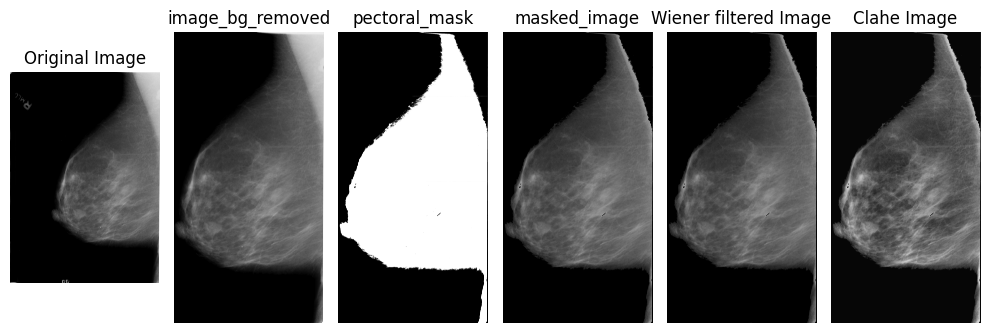

In [140]:
start_time_main = time.time()
dicom_image_path = Y_train['image_path'][3]
dicom_elements = dicom_image_path.split('/')

image_path = dicom_elements[1] + '/' + dicom_elements[2] + '/' + dicom_elements[3]
imagew = cv2.imread(image_path, cv2.IMREAD_COLOR)

image_bg_removed = background_removal(imagew)

clahe_enhanced, wiener_filtered, masked_image, pectoral_mask = pectoral_reduction(image_bg_removed)

end_time = time.time()
duration_ms = (end_time - start_time_main) * 1000
print("Time duration:  ", duration_ms, " milliseconds")
# plt.imshow(image, cmap='gray')


fig, axes = plt.subplots(1, 6, figsize=(10, 4))
axes[0].imshow(imagew)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(image_bg_removed)
axes[1].set_title('image_bg_removed')
axes[1].axis('off')
axes[2].imshow(pectoral_mask, cmap='gray')
axes[2].set_title('pectoral_mask')
axes[2].axis('off')
axes[3].imshow(masked_image, cmap='gray')
axes[3].set_title('masked_image')
axes[3].axis('off')
axes[4].imshow(wiener_filtered, cmap='gray')
axes[4].set_title('Wiener filtered Image')
axes[4].axis('off')
axes[5].imshow(clahe_enhanced, cmap='gray')
axes[5].set_title('Clahe Image')
axes[5].axis('off')
plt.tight_layout()
plt.show()

In [ ]:

import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms

def pre_process(image):
    # Implement your custom preprocessing logic here
    # For example, you can use torchvision.transforms or custom transformations
    preprocess_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess_transform(image)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_paths = [...]  # List of paths to your images
        self.transforms = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = self.load_image(image_path)
        image = pre_process(image)
        return image

    def load_image(self, path):
        # Implement loading image logic here
        # Example using PIL:
        from PIL import Image
        image = Image.open(path)
        return image

# Load pre-trained AlexNet
alexnet = models.alexnet(pretrained=True)

# Freeze all layers except the last ones
for param in alexnet.parameters():
    param.requires_grad = False

# Modify the last fully connected layer for your specific task
num_classes = 10
alexnet.classifier[6] = nn.Linear(4096, num_classes)

# Define your data directory and create a custom dataset
data_dir = 'your_data_directory'
custom_dataset = CustomDataset(data_dir)

# Use DataLoader with the custom dataset
batch_size = 32  # Adjust as needed
data_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 5  # Adjust as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet.to(device)

for epoch in range(num_epochs):
    for inputs in data_loader:
        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = alexnet(inputs)
        # Assuming you have labels, add them to the training loop accordingly
        # loss = criterion(outputs, labels)
        # loss.backward()
        # optimizer.step()

    # Print training progress
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

# Save the trained model if needed
torch.save(alexnet.state_dict(), 'your_model.pth')
